# Onclusive Machine Learning Challenge
## Task:
Build an ML system to verify the veracity of claims. Please clearly outline steps and
demonstrate the performance of the final model.
While we strongly encourage creativity in this challenge, you might find some of the pre-
trained transformers available in Huggingface helpful.
Huggingface transformers: https://huggingface.co/models

## Dataset:

- PUBHEALTH is a comprehensive dataset for explainable automated fact-checking of
public health claims. Each instance in the PUBHEALTH dataset has an associated
veracity label (true, false, unproven, mixture). Furthermore each instance in the dataset
has an explanation text field. The explanation is a justification for which the claim has
been assigned a particular veracity label.
Dataset link: https://huggingface.co/datasets/health_fact


Initialize COlab environment

In [17]:
## If we use Colab
# mounts Google Drive to the Colab VM
from google.colab import drive, files
drive.mount('/content/drive/',force_remount=True)

# project  foldername
FOLDERNAME ="Mon Drive/Colab Notebooks/Onclusive_work/"#fake_flow

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Mounted at /content/drive/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download and Import Packages
We use simpletransformers based on Hugginface library.
https://simpletransformers.ai/docs/installation/

In [18]:
!pip install nltk
!pip install transformers
!pip install datasets
!pip install simpletransformers
!pip install seaborn
# !pip install -U sentence-transformers

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,classification_report

from nltk.tokenize.treebank import TreebankWordTokenizer,TreebankWordDetokenizer

import tqdm
import torch
import torch.nn as nn
import transformers
import datetime
import seaborn as sns
%matplotlib inline
sns.set()
# Load the TensorBoard notebook extension
# import  tensorflow as tf
# %load_ext tensorboard
# import datetime, os


## Import Data and Data Processing

In [20]:
### Import Dataset using Huggingface

from datasets import list_datasets, list_metrics, load_dataset, load_metric

dataset = load_dataset("health_fact")

Using custom data configuration default
Reusing dataset health_fact (/root/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19)


  0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
# Informations on the dataset (description, citation, size, splits, format...)
dataset

DatasetDict({
    train: Dataset({
        features: ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects'],
        num_rows: 9832
    })
    test: Dataset({
        features: ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects'],
        num_rows: 1235
    })
    validation: Dataset({
        features: ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects'],
        num_rows: 1225
    })
})

In [22]:
print(f"👉 Dataset len(dataset): {len(dataset)}")
print("\n👉 First item 'dataset[0]':")
print(dataset["train"][1]["claim"])

👉 Dataset len(dataset): 3

👉 First item 'dataset[0]':
Annual Mammograms May Have More False-Positives


In [23]:
#column names and types 
print("Column names:")
print(dataset.column_names)


Column names:
{'train': ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects'], 'test': ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects'], 'validation': ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects']}


In [24]:
# Datasets also have shapes informations
print("The number of rows", dataset.num_rows, "also available as len(dataset)", len(dataset))
print("The number of columns", dataset.num_columns)
print("The shape (rows, columns)", dataset.shape)

The number of rows {'train': 9832, 'test': 1235, 'validation': 1225} also available as len(dataset) 3
The number of columns {'train': 9, 'test': 9, 'validation': 9}
The shape (rows, columns) {'train': (9832, 9), 'test': (1235, 9), 'validation': (1225, 9)}


In [25]:
# visualize some lines
for i in range(10):
  print(dataset["train"][i])

{'claim_id': '15661', 'claim': '"The money the Clinton Foundation took from from foreign governments while Hillary Clinton was secretary of state ""is clearly illegal. … The Constitution says you can’t take this stuff."', 'date_published': 'April 26, 2015', 'explanation': '"Gingrich said the Clinton Foundation ""took money from from foreign governments while (Hillary Clinton) was secretary of state. It is clearly illegal. … The Constitution says you can’t take this stuff."" A clause in the Constitution does prohibit U.S. officials such as former Secretary of State Hillary Clinton from receiving gifts, or emoluments, from foreign governments. But the gifts in this case were donations from foreign governments that went to the Clinton Foundation, not Hillary Clinton. She was not part of the foundation her husband founded while she was secretary of state. Does that violate the Constitution? Some libertarian-minded constitutional law experts say it very well could. Others are skeptical. Wha

In [26]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [27]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [28]:
!pip3  list | grep tensorflow #2.8 gpu

tensorflow                    2.8.0+zzzcolab20220506162203
tensorflow-datasets           4.0.1
tensorflow-estimator          2.8.0
tensorflow-gcs-config         2.8.0
tensorflow-hub                0.12.0
tensorflow-io-gcs-filesystem  0.25.0
tensorflow-metadata           1.8.0
tensorflow-probability        0.16.0


In [29]:
!pip3  list | grep  keras

keras                         2.8.0
keras-vis                     0.4.1


## First preprocessing 

In [30]:
# Get split of data and reformat in dataframe
train_data = pd.DataFrame.from_dict(dataset["train"])
# print(train_data.info())

valid_data = pd.DataFrame.from_dict(dataset["validation"])
# print(valid_data.info())

test_data = pd.DataFrame.from_dict(dataset["test"])
# print(test_data.info())

In [31]:
# train_data
valid_data

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,34656,A baby died at an unnamed medical facility be...,"November 10, 2015",Fellow Twitter users suggested @FierceFemtivis...,Kim LaCapria,"On 8 November 2015, former Twitter user @Fierc...",http://webcache.googleusercontent.com/search?q...,3,"Politics, fiercefemtivist, racism"
1,3632,Bat from Shawnee County tests positive for rab...,,A bat found in northeastern Kansas has tested ...,,Topeka television station KSNT reports that th...,https://www.ksnt.com/news/bat-tests-positive-f...,2,"Rabies, Health, General News, Kansas, Bats, To..."
2,29558,Germany has banned pork from school canteens b...,"March 7, 2016",What's true: Some politicians complained that ...,Kim LaCapria,"On 7 March 2016, British tabloid Express repor...",http://bnp.org.uk/news/regional/bnp-victory-br...,0,Politics
3,8416,Coronavirus prompts Canada to roll out safe dr...,"April 16, 2020",Canada’s Pacific province of British Columbia ...,Tessa Vikander,"In March, the Canadian government urged provin...",,2,Health News
4,7169,"Wayne National Forest plans fires for tree, wi...",,"Nearly 2,000 acres of Wayne National Forest in...",,Forest officials say scientists who study nati...,,2,"Plants, Wildlife, Health, Wildlife health, For..."
...,...,...,...,...,...,...,...,...,...
1220,39818,There are reports of suicides and even murd...,"March 17, 2015","Deadly Aftermath of Harold Camping's May 21, 2...",\n\nRich Buhler & Staff\n\n,Harold Camping is a self-taught Bible teache...,https://www.truthorfiction.com/category/crime-...,1,"Crime / Police, Religious"
1221,15793,"The state of Florida has seen ""double-digit dr...","March 18, 2015","Pitman said Florida has seen ""double-digit dro...",Joshua Gillin,As the Legislature considers changing rules fo...,"http://www.cdc.gov/mmwr/pdf/ss/ss6304.pdf, htt...",2,"Alcohol, Children, Florida, Susan Pitman,"
1222,5271,Officials probe respiratory illness at Quincy ...,,State officials are investigating several case...,,The (Quincy) Herald-Whig reports the departmen...,https://www.whig.com/20190817/agencies-report-...,2,"Quincy, Health, General News, Legionnaires dis..."
1223,9002,Sylentis announces the results of tivanisiran ...,"May 10, 2018",This news release focuses on a study of a new ...,"Earle Holland,Harold J. DeMonaco, MS,Kathlyn S...",There is no discussion of the potential cost o...,https://www.healthnewsreview.org/wp-content/up...,1,"dry eye,Pharmamar"


Labels available in the dataset:-1=?, 0=false  ,1=mixture,2=true,3=unproven.
We need to delete the label -1.Then we change columns type and rename claim to text and label to labels. We delete some unused columns.


In [32]:
#remove label -1
train_data = train_data[train_data['label']!=-1]
valid_data = valid_data[valid_data['label']!=-1]
test_data = test_data[test_data['label']!=-1]

#change  columns type
data_types={ 'claim':'string',  'explanation':'string', 'fact_checkers':'string', 'main_text':'string', 'sources':'string',  'subjects':'string',
            'claim_id':'int','label':'int'}
# data_types = {'claim': 'str', 'explanation': 'str', 'fact_checkers': 'str', 'main_text': 'str',
#                           'sources': 'str', 'subjects': 'str',
#                           'claim_id': 'int', 'label': 'int'}

train_data = train_data.astype(data_types)
valid_data = valid_data.astype(data_types)
test_data = test_data.astype(data_types)

#rename column claim to text and label to labels
train_data = train_data.rename({'claim': 'text','label': 'labels'}, axis=1)
valid_data = valid_data.rename({'claim': 'text','label': 'labels'}, axis=1)
test_data = test_data.rename({'claim': 'text','label': 'labels'}, axis=1)
# train_data = train_data[["content", "main_text", "explanation", "label"]]

# combine claim and main text
# train_data['content'] = train_data['claim'] + train_data['main_text']
# valid_data['content'] = valid_data['claim'] + valid_data['main_text']
# test_data['content'] = test_data['claim'] + test_data['main_text']

#delete some unused columns
train_data = train_data.drop(columns=['fact_checkers', 'sources','date_published'])
valid_data = valid_data.drop(columns=['fact_checkers', 'sources', 'date_published'])
test_data = test_data.drop(columns=['fact_checkers', 'sources', 'date_published'])


In [33]:
## check types 
print(train_data.info())
print(valid_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9804 entries, 0 to 9831
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   claim_id     9804 non-null   int64 
 1   text         9804 non-null   string
 2   explanation  9804 non-null   string
 3   main_text    9804 non-null   string
 4   labels       9804 non-null   int64 
 5   subjects     9804 non-null   string
dtypes: int64(2), string(4)
memory usage: 536.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214 entries, 0 to 1224
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   claim_id     1214 non-null   int64 
 1   text         1214 non-null   string
 2   explanation  1214 non-null   string
 3   main_text    1214 non-null   string
 4   labels       1214 non-null   int64 
 5   subjects     1214 non-null   string
dtypes: int64(2), string(4)
memory usage: 66.4 KB
None
<class 'pandas.core.f

In [34]:
test_data

,claim_id,text,explanation,main_text,labels,subjects
0,33456,A mother revealed to her child in a letter aft...,The one-eyed mother story expounds upon two mo...,"In April 2005, we spotted a tearjerker on the ...",0,Glurge Gallery
1,2542,Study says too many Americans still drink too ...,"On any given day in the United States, 18 perc...",That means the great majority of Americans sta...,2,Health News
2,26678,Viral image Says 80% of novel coronavirus case...,The website Information is Beautiful published...,"Amid the spread of the novel coronavirus, many...",2,"Facebook Fact-checks, Coronavirus, Viral image,"
3,40705,An email says that 9-year old Craig Shergold o...,Send greeting or business cards to cancer vict...,Craig Shergold is real and in 1989...,0,"Inspirational, Pleas"
4,35718,"Employees at a Five Guys restaurant in Daphne,...","What's undetermined: As of this writing, Five ...","In July 2020, amid a new wave of nationwide pr...",3,Law Enforcement
...,...,...,...,...,...,...
1230,3295,Christmas miracle for Florida dog whose heart ...,A Florida man was hoping for a Christmas mirac...,The heart of Gerald Ford’s 1-year-old French b...,2,"Animals, Health, Florida, General News, Gaines..."
1231,6904,Another dolphin dies at Arizona aquatic facility.,A fourth dolphin has died at a Phoenix-area aq...,A statement from Dolphinaris Arizona in Scotts...,2,"Arizona, Animals, Phoenix, Health, Dolphins"
1232,13874,"What the facts say"" is ... ""the best scenario ...","Priebus said, ""What the facts say"" is ... ""the...",Republican National Committee chairman Reince ...,0,"National, Children, Race and Ethnicity, Reince..."
1233,2847,FDA advisory panel rejects J&J drug for acute ...,Johnson & Johnson’s anticoagulant Xarelto shou...,"The panel voted 10 to 0, with one abstention, ...",2,Health News


In [35]:
# train_data.shape ##(9804, 9)


In [36]:
# ## Visualize and count cells with " "
# counter=0
# for i in range(len(train_data)):
#   if train_data["subjects"].iloc[i]==" ":
#     counter+=1
#     print("id= {}= value {}".format(i,train_data["subjects"].iloc[i]))
# print("Total without main text=",counter)

# ## fact checkers 2222 empty
# ## sources 4550, data=5, subjects=773

 Now, we see the content of all sets, we see the frequency of data associated to each label.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


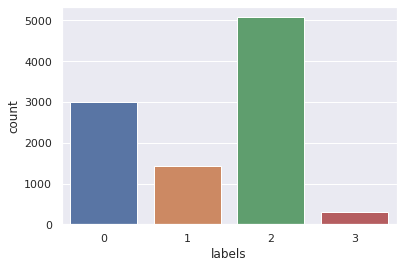

In [37]:
#Train data
sns.countplot("labels",data=train_data)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


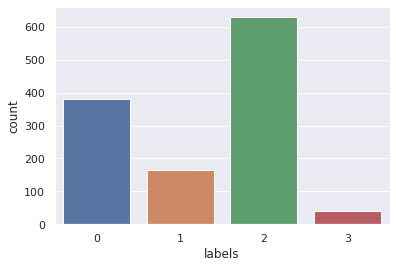

In [38]:
#Valid data
sns.countplot("labels",data=valid_data)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


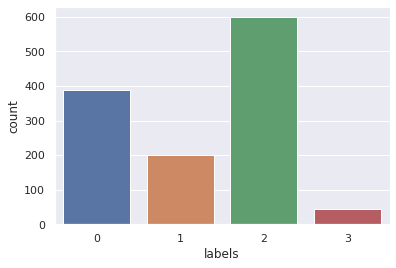

In [39]:
#Test data
sns.countplot("labels",data=test_data)


Visualize repartition of labels in train/valid/test sets



In [40]:
#see repartition of labels
print(np.unique(train_data["labels"]))
train_data.groupby("labels").count()

[0 1 2 3]


,claim_id,text,explanation,main_text,subjects
labels,,,,,
0,3001,3001,3001,3001,3001
1,1434,1434,1434,1434,1434
2,5078,5078,5078,5078,5078
3,291,291,291,291,291


In [41]:
valid_data.groupby("labels").count()

,claim_id,text,explanation,main_text,subjects
labels,,,,,
0,380,380,380,380,380
1,164,164,164,164,164
2,629,629,629,629,629
3,41,41,41,41,41


In [42]:
test_data.groupby("labels").count()

,claim_id,text,explanation,main_text,subjects
labels,,,,,
0,388,388,388,388,388
1,201,201,201,201,201
2,599,599,599,599,599
3,45,45,45,45,45


## Preprocessing
In this part, I implement a tokenizer with TreebankTokenizer and use it to split sentences into tokens and get few statistics on the distribution of the dataset.

In [43]:
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
def treebank_tokenize(s):
    return tokenizer.tokenize(s)

def counter_words(df_data,col="claim"):
  counttext=[]
  for elem in df_data[col]:
    val= len(treebank_tokenize(str(elem)))
    counttext.append(val)
  print("fram=",counttext[:5])
  df_data['word_count'] = counttext
  return df_data

# text = "We notice that convolution has been very successful in extracting local"
# print(preprocess(text))

In [59]:
train_data.head()

,claim_id,text,explanation,main_text,labels,subjects,word_count
0,15661,"""The money the Clinton Foundation took from fr...","""Gingrich said the Clinton Foundation """"took m...","""Hillary Clinton is in the political crosshair...",0,"Foreign Policy, PunditFact, Newt Gingrich,",36
1,9893,Annual Mammograms May Have More False-Positives,This article reports on the results of a study...,While the financial costs of screening mammogr...,1,"Screening,WebMD,women's health",6
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,This news release describes five-year outcomes...,The news release quotes lead researcher Robert...,1,"Association/Society news release,Cancer",14
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","While the story does many things well, the ove...","The story does discuss costs, but the framing ...",2,"Cancer,WebMD,women's health",10
4,11276,Some appendicitis cases may not require ’emerg...,We really don’t understand why only a handful ...,"""Although the story didn’t cite the cost of ap...",2,,10
...,...,...,...,...,...,...,...
9827,35948,The Sturgis motorcycle rally in 2020 resulted ...,"They want to know if mass-events (protests, co...","In September 2020, social media was abuzz over...",3,"Politics Medical, COVID-19",13
9828,401,AstraZeneca's infant respiratory drug prioriti...,Britain’s AstraZeneca said a potential medicin...,The “Breakthrough Therapy” and “Prime” designa...,2,Health News,11
9829,2023,Testicular cancer deaths double with after 40 ...,Men diagnosed with testicular cancer at 40 yea...,This was true even when initial treatment and ...,2,Health News,9
9830,38118,The FDA published “conclusive proof” that the...,FDA Confirms DTaP Vaccine Causes Autism in Nov...,The FDA hasn’t confirmed a link between DTaP v...,0,Medical,17


fram= [36, 6, 14, 10, 10]


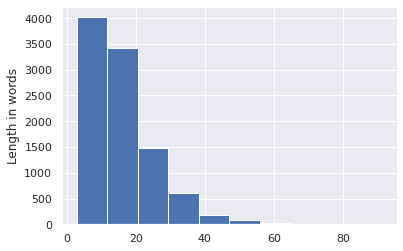

In [44]:
# visualize the frequency of claim by length ON TRAIN SET
train_data = counter_words(train_data,col="text")
_ = train_data['word_count'].hist().set_ylabel("Frequency")

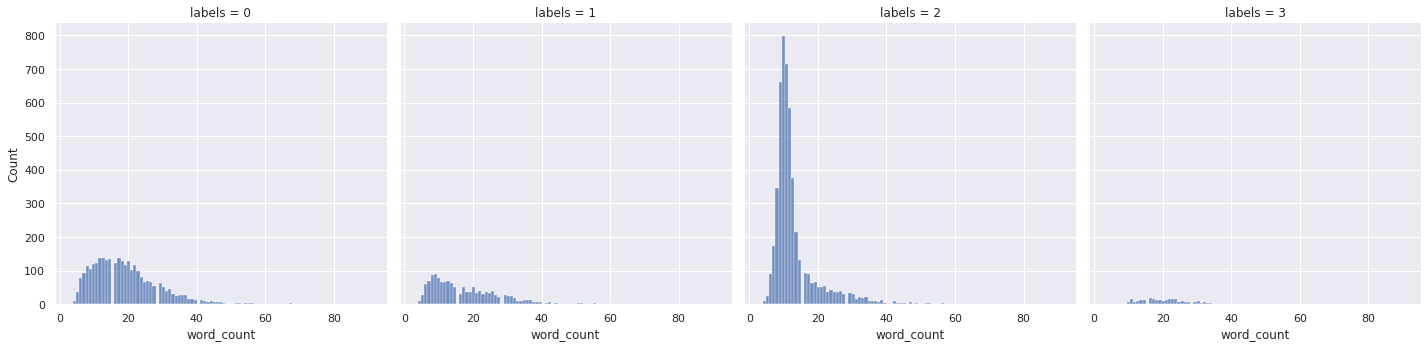

In [67]:
# visualize  the frequency of claim by length and labels
sns.displot(train_data, x="word_count", col="labels",multiple="dodge")

fram= [23, 9, 14, 12, 11]


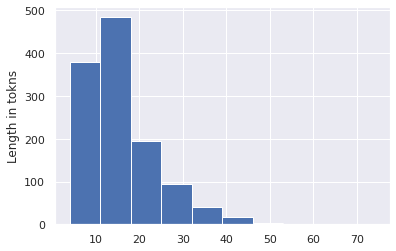

In [54]:
# visualize  the frequency of claim by length ON VALID SET
valid_data = counter_words(valid_data,col="text")
_ = valid_data['word_count'].hist().set_ylabel("Frequency")

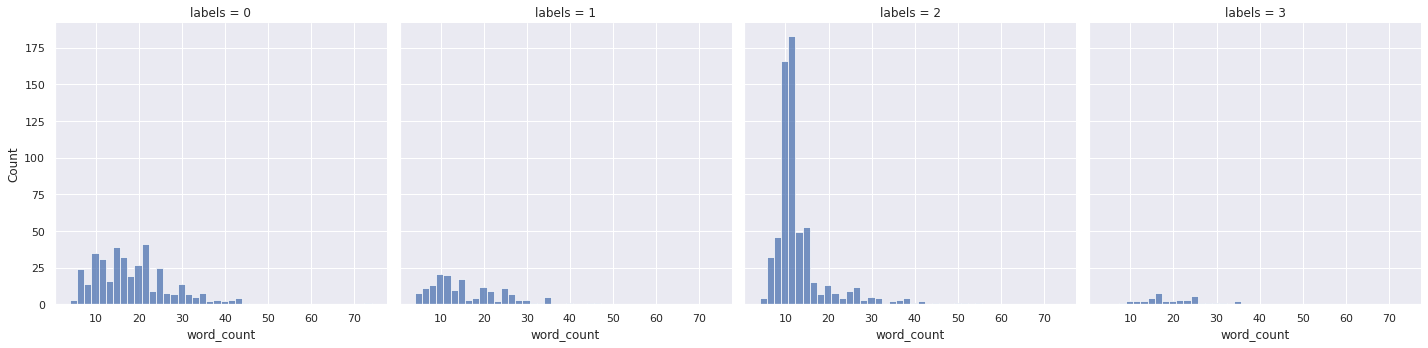

In [68]:
# visualize  the frequency of claim by length and labels
sns.displot(valid_data, x="word_count", col="labels",multiple="dodge")

fram= [27, 10, 13, 59, 18]


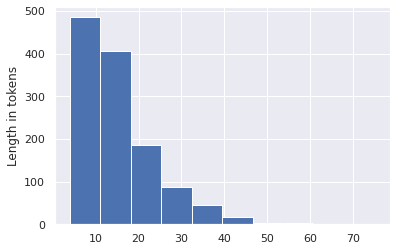

In [56]:
# visualize  the frequency of claim by length on TEST SET
test_data = counter_words(test_data,col="text")
_ = test_data['word_count'].hist().set_ylabel("Frequency")

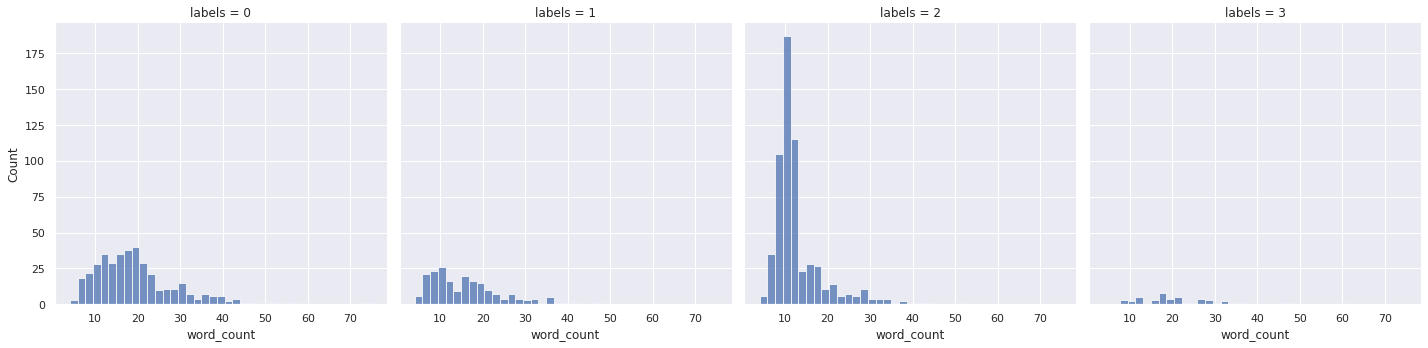

In [69]:
# visualize  the frequency of claim by length and labels
sns.displot(test_data, x="word_count", col="labels",multiple="dodge")

# Train first model Roberta base


In [ ]:
np.unique(train_data["labels"])


array([0, 1, 2, 3])

In [71]:

# Save scores in json file
def save(path,result,name):
  import json
  # create json object from dictionary
  json = json.dumps(result)
  # open file for writing, "w" 
  f = open(path+str(name)+".json","w")
  # write json object to file
  f.write(json)
  # close file
  f.close()
  
path ='/content/drive/My Drive/Colab Notebooks/Onclusive_work/'

In [ ]:
# Use ROBERTA model with simplertransformers
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# model="bert"
# modelname= "bert-base-multilingual-cased"

model="roberta"
modelname= "roberta-base"

train_df = train_data[['text', 'labels']]
valid_df =  valid_data[['text', 'labels']]
test_df=test_data[['text', 'labels']]
# train_df.columns = ["text", "labels"]
# valid_df.columns = ["text", "labels"]
# test_df.columns = ["text", "labels"]

# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=10, train_batch_size=64,
                                        output_dir=path+"outputTransformer", overwrite_output_dir=True,
                                        use_early_stopping=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Create a ClassificationModel num_labels=4, use_cuda=device,cuda_device=0, 
model = ClassificationModel(
      model, modelname, args=model_args,use_cuda=True,  num_labels=4
    )


# Train the model 
model.train_model(train_df, acc=classification_report)
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(valid_df, acc=classification_report)
print("result=", result)
print("model_outputs=", model_outputs)
print("wrong=", wrong_predictions)

# model.convert_to_onnx(path+str(modelname)+"_onnx_outputs")
## #Save the results in a file

save(path, result,name=str(model)+"_"+str(modelname)+'_results2')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/9804 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_4_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to /content/drive/My Drive/Colab Notebooks/Onclusive_work/outputTransformer.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1214 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_4_2


Running Evaluation:   0%|          | 0/152 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.4804457740308687, 'acc': '              precision    recall  f1-score   support\n\n         0.0       0.61      0.63      0.62       380\n         1.0       0.32      0.37      0.34       164\n         2.0       0.84      0.82      0.83       629\n         3.0       0.53      0.22      0.31        41\n\n    accuracy                           0.68      1214\n   macro avg       0.58      0.51      0.53      1214\nweighted avg       0.69      0.68      0.68      1214\n', 'eval_loss': 1.4224181404631389}


result= {'mcc': 0.4804457740308687, 'acc': '              precision    recall  f1-score   support\n\n         0.0       0.61      0.63      0.62       380\n         1.0       0.32      0.37      0.34       164\n         2.0       0.84      0.82      0.83       629\n         3.0       0.53      0.22      0.31        41\n\n    accuracy                           0.68      1214\n   macro avg       0.58      0.51      0.53      1214\nweighted avg       0.69      0.68      0.68      1214\n', 'eval_loss': 1.4224181404631389}
model_outputs= [[ 1.07421875  1.78417969 -3.92578125  2.07226562]
 [-2.640625   -2.5         6.52734375 -2.078125  ]
 [ 5.64453125 -1.44824219 -2.94335938 -1.37109375]
 ...
 [-2.77929688 -2.63867188  6.6015625  -1.765625  ]
 [ 2.83984375  2.58984375 -1.62402344 -4.4453125 ]
 [-2.80859375 -2.5546875   6.60546875 -1.87304688]]
wrong= [{'guid': 6, 'text_a': 'The state of Michigan threatened local beavers with a $10,000 per day fine for failing to remove their dams.', 'text_b

In [ ]:
# result= {'mcc': 0.46946206854943884, 'acc': '              precision    recall  f1-score   support\n
# \n         0.0       0.61      0.64      0.63       380
# \n         1.0       0.32      0.30      0.31      164
# \n         2.0       0.82      0.82      0.82       629
# \n         3.0       0.41      0.27      0.32       41\n\n  
#   accuracy                           0.68     
#    1214\n   macro avg       0.54      0.51      0.52      
#    1214\nweighted avg       0.67      0.68      0.67      
#    1214\n', 'eval_loss': 0.8233928405924847}

# simpletransformers.classification.classification_model:{'mcc': 0.4804457740308687, 'acc': '    
#     precision    recall  f1-score   support\n
#     \n         0.0       0.61      0.63      0.62       380\n 
#     1.0       0.32      0.37      0.34       164\n 
#     2.0       0.84      0.82      0.83       629\n       
#     3.0       0.53      0.22      0.31        41\n\n   
#      accuracy                           0.68      1214\n 
#       macro avg       0.58      0.51      0.53      1214\n
#       weighted avg       0.69      0.68      0.68      1214\n', 'eval_loss': 1.4224181404631389}

# result= {'mcc': 0.4804457740308687, 'acc': '            
#   precision    recall  f1-score   support\n\n         0.0       0.61      0.63      0.62       380
#   \n         1.0       0.32      0.37      0.34       164
#   \n         2.0       0.84      0.82      0.83       629\n    
#        3.0       0.53      0.22      0.31        41\n\n   
#  accuracy                           0.68      1214\n 
#    macro avg       0.58      0.51      0.53      1214\n
#    weighted avg       0.69      0.68      0.68      1214\n', 'eval_loss': 1.4224181404631389}


In [ ]:
# F1 = 2 * (precision * recall) / (precision + recall)


In [ ]:
# test_df=test_data[['text', 'labels']]
# test_df

,text,labels
0,A mother revealed to her child in a letter aft...,0
1,Study says too many Americans still drink too ...,2
2,Viral image Says 80% of novel coronavirus case...,2
3,An email says that 9-year old Craig Shergold o...,0
4,"Employees at a Five Guys restaurant in Daphne,...",3
...,...,...
1230,Christmas miracle for Florida dog whose heart ...,2
1231,Another dolphin dies at Arizona aquatic facility.,2
1232,"What the facts say"" is ... ""the best scenario ...",0
1233,FDA advisory panel rejects J&J drug for acute ...,2


In [73]:
# from simpletransformers.classification import ClassificationModel, ClassificationArgs
# import pandas as pd
# import logging
# logging.basicConfig(level=logging.INFO)
# transformers_logger = logging.getLogger("transformers")
# transformers_logger.setLevel(logging.WARNING)

# # model="bert"
# # modelname= "bert-base-multilingual-cased"

# model="roberta"
# modelname= "roberta-base"

# train_df = train_data[['text', 'labels']]
# valid_df =  valid_data[['text', 'labels']]
# test_df=test_data[['text', 'labels']]
# # train_df.columns = ["text", "labels"]
# # valid_df.columns = ["text", "labels"]
# # test_df.columns = ["text", "labels"]

# # Optional model configuration
# model_args = ClassificationArgs(num_train_epochs=10, train_batch_size=64,
#                                         output_dir=path+"outputTransformer", overwrite_output_dir=False,
#                                         use_early_stopping=True)


# # os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # Create a ClassificationModel num_labels=4, use_cuda=device,cuda_device=0, 
# model = ClassificationModel(
#       model, modelname, args=model_args,use_cuda=False,  num_labels=4
#     )

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [76]:
# Make predictions with the model
test_df=test_data[['text', 'labels']]
predictions, raw_outputs, wrong2 = model.eval_model(test_df,acc=classification_report )
print("result=", predictions)
print("model_outputs=", raw_outputs)
print("wrong=", wrong2)

save(path, predictions, name=str(model)+"_"+str(modelname)+"_preds")

In [ ]:
#TEST result= {'mcc': 0.41876858522858096, 
# 'acc': '              precision    recall  f1-score   support\n\n        
#  0.0       0.56      0.63      0.60       388\n       
#    1.0       0.30      0.21      0.25       201\n     
#     2.0       0.78      0.81      0.79       599\n     
#     3.0       0.36      0.29      0.32        45\n\n  
#      accuracy                           0.64    
#     1233\n   macro avg       0.50      0.49      0.49     
#     1233\nweighted avg       0.62      0.64      0.63      1233\n', 'eval_loss': 0.9172410057437035}


In [74]:
# Make predictions with the model
# predictions, raw_outputs = model.predict( test_data[['text']])

# Train second model ALBERT base v2

In [ ]:
# Use ALBERT model wit simpletransformers
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# model="bert"
# modelname= "bert-base-multilingual-cased"
# bert-base-multilingual-cased, bert-base-uncased

model="albert"
modelname= "albert-base-v2"

train_df = train_data[['text', 'labels']]
valid_df =  valid_data[['text', 'labels']]
test_df=test_data[['text', 'labels']]
# train_df.columns = ["text", "labels"]
# valid_df.columns = ["text", "labels"]
# test_df.columns = ["text", "labels"]


# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=10, train_batch_size=64,
                                        output_dir=path+"outputAlbert", overwrite_output_dir=True,
                                        use_early_stopping=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Create a ClassificationModel with params num_labels=4, use_cuda=device,cuda_device=0, 
modelalbert = ClassificationModel(
      model, modelname, args=model_args,use_cuda=True,  num_labels=4
    )

# Train the model 
modelalbert.train_model(train_df, acc=classification_report,show_running_loss =True,output_dir =path+"outputAlbert")
# Evaluate the model
resultalbert, model_outputsalbert, wrong_predictionsabert = modelalbert.eval_model(valid_df, acc=classification_report)
print("result=", resultalbert)
print("model_outputs=", model_outputsalbert)
print("wrong=", wrong_predictionsabert)

#Save the results in a file
# model.convert_to_onnx(path+str(modelname)+"_onnx_outputs")
save(path, resultalbert,name=str(model)+"_"+str(modelname)+'_results')


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

  0%|          | 0/9804 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_albert_128_4_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/154 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of albert model complete. Saved to /content/drive/My Drive/Colab Notebooks/Onclusive_work/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1214 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_albert_128_4_2


Running Evaluation:   0%|          | 0/152 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.41690102144586894, 'acc': '              precision    recall  f1-score   support\n\n         0.0       0.55      0.59      0.57       380\n         1.0       0.30      0.26      0.28       164\n         2.0       0.79      0.80      0.80       629\n         3.0       0.47      0.34      0.39        41\n\n    accuracy                           0.64      1214\n   macro avg       0.53      0.50      0.51      1214\nweighted avg       0.64      0.64      0.64      1214\n', 'eval_loss': 1.614544536232164}


result= {'mcc': 0.41690102144586894, 'acc': '              precision    recall  f1-score   support\n\n         0.0       0.55      0.59      0.57       380\n         1.0       0.30      0.26      0.28       164\n         2.0       0.79      0.80      0.80       629\n         3.0       0.47      0.34      0.39        41\n\n    accuracy                           0.64      1214\n   macro avg       0.53      0.50      0.51      1214\nweighted avg       0.64      0.64      0.64      1214\n', 'eval_loss': 1.614544536232164}
model_outputs= [[-0.56445312 -0.3203125  -2.01953125  2.79492188]
 [-2.8515625  -2.50585938  6.55859375 -2.45117188]
 [ 5.90625    -0.79492188 -2.58007812 -1.48242188]
 ...
 [-2.921875   -2.5234375   6.66796875 -2.44140625]
 [ 3.52148438  2.01171875 -2.34960938 -2.47070312]
 [-3.16601562 -2.22265625  6.2734375  -2.63671875]]
wrong= [{'guid': 6, 'text_a': 'The state of Michigan threatened local beavers with a $10,000 per day fine for failing to remove their dams.', 'text_b

NameError: ignored

In [ ]:

## Pedictions on Valid data with ALBERT
# result= {'mcc': 0.41690102144586894, 'acc': '              
# precision    recall  f1-score   support\n\n         0.0       0.55      0.59      0.57       380
# \n         1.0       0.30      0.26      0.28       164
# \n         2.0       0.79      0.80      0.80       629
# \n         3.0       0.47      0.34      0.39        41\n\n   
#  accuracy                           0.64      1214\n  
#   macro avg       0.53      0.50      0.51      1214\n
#   weighted avg       0.64      0.64      0.64      1214\n', 'eval_loss': 1.614544536232164}


In [ ]:
# Make predictions with the model ALBERT

albertpredictions, albertraw_outputs, albertwrong2 = modelalbert.eval_model(test_df,acc=classification_report )
print("result=", albertpredictions)
print("model_outputs=", albertraw_outputs)
print("wrong=", albertwrong2)
# model.convert_to_onnx(path+str(modelname)+"_onnx_outputs")
save(path, albertpredictions, name=str(model)+"_"+str(modelname)+"_preds")

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1233 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_albert_128_4_2


Running Evaluation:   0%|          | 0/155 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.3750819522124085, 'acc': '              precision    recall  f1-score   support\n\n         0.0       0.54      0.60      0.57       388\n         1.0       0.31      0.26      0.28       201\n         2.0       0.76      0.76      0.76       599\n         3.0       0.25      0.16      0.19        45\n\n    accuracy                           0.61      1233\n   macro avg       0.46      0.44      0.45      1233\nweighted avg       0.60      0.61      0.60      1233\n', 'eval_loss': 1.8215531977914994}


result= {'mcc': 0.3750819522124085, 'acc': '              precision    recall  f1-score   support\n\n         0.0       0.54      0.60      0.57       388\n         1.0       0.31      0.26      0.28       201\n         2.0       0.76      0.76      0.76       599\n         3.0       0.25      0.16      0.19        45\n\n    accuracy                           0.61      1233\n   macro avg       0.46      0.44      0.45      1233\nweighted avg       0.60      0.61      0.60      1233\n', 'eval_loss': 1.8215531977914994}
model_outputs= [[ 5.25390625 -2.21484375 -0.64697266 -1.453125  ]
 [-2.90625    -2.57226562  6.38671875 -2.5546875 ]
 [-0.82128906 -3.0390625   4.03515625 -1.49707031]
 ...
 [ 4.0078125  -0.95703125  0.61865234 -3.21484375]
 [-2.84960938 -2.66601562  6.66015625 -2.67773438]
 [ 2.3828125  -1.95214844  1.578125   -2.50390625]]
wrong= [{'guid': 3, 'text_a': 'An email says that 9-year old Craig Shergold of Carshalton, Great Britain is dying of Cancer.\xa0 As a dying wish, he 

In [ ]:
# result= {'mcc': 0.3750819522124085, 'acc': '              
# precision    recall  f1-score   support\n\n         
# 0.0       0.54      0.60      0.57       388
# \n         1.0       0.31      0.26      0.28       201
# \n         2.0       0.76      0.76      0.76       599
# \n         3.0       0.25      0.16      0.19        45\n\n 
#    accuracy                           0.61      1233\n  
#    macro avg       0.46      0.44      0.45      1233\n
#    weighted avg       0.60      0.61      0.60      1233\n', 'eval_loss': 1.8215531977914994}


# Use of CONVBERT

In [ ]:
## Use CONVBERT
import torch

from transformers import ConvBertTokenizer, ConvBertForSequenceClassification

tokenizer = ConvBertTokenizer.from_pretrained("YituTech/conv-bert-base")

model = ConvBertForSequenceClassification.from_pretrained("YituTech/conv-bert-base", problem_type="multi_label_classification")
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()

model.config.id2label[predicted_class_id]

Downloading:   0%|          | 0.00/260k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/403M [00:00<?, ?B/s]

Some weights of ConvBertForSequenceClassification were not initialized from the model checkpoint at YituTech/conv-bert-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'LABEL_0'

In [ ]:
# To train a model on `num_labels` classes, you can pass `num_labels=num_labels` to `.from_pretrained(...)`
import torch
from transformers import ConvBertTokenizer, ConvBertForSequenceClassification

tokenizer = ConvBertTokenizer.from_pretrained("YituTech/conv-bert-base")

num_labels = len(model.config.id2label)
print("num_labels=",num_labels)
model = ConvBertForSequenceClassification.from_pretrained(
    "YituTech/conv-bert-base", num_labels=num_labels, problem_type="multi_label_classification"

)
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
print(inputs)
labels = torch.nn.functional.one_hot(torch.tensor([predicted_class_id]), num_classes=num_labels).to(
    torch.float)

loss = model(**inputs, labels=labels).loss
loss.backward()

num_labels= 2


Some weights of ConvBertForSequenceClassification were not initialized from the model checkpoint at YituTech/conv-bert-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(inputs)

{'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


In [ ]:
## from https://github.com/huggingface/notebooks/blob/main/examples/text_classification.ipynb
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenized_imdb = imdb.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

In [ ]:
best_run

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()